# Project 2

## Authors: Declan Sheehan, Jack Stoetzel

### Description: In this project, we will create two machine learning algorithms and apply it toward one of the datasets in project one.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import operator
from numpy import *

# Import data from csv file. CSV file: 10 Columns x 35157 Rows.
COVID = pd.read_csv('data/full_grouped.csv', skiprows=[0], header = None, skipinitialspace = True,
                names = ['date', 'count-reg', 'case', 'death', 'recover', 'active', 'ncase', 'ndeath', 'nrecover', 'who'])

COVID2 = pd.read_csv('data/cases_data.csv', skiprows=[0], header=None, skipinitialspace=True,
                    names=['Country', 'Population', 'Total Cases'])

COVID3 = pd.read_csv('data/other_full_grouped.csv', skiprows=[0], header = None, skipinitialspace = True,
                names = ['date', 'count_reg', 'case', 'death', 'recover', 'active', 'ncase', 'ndeath', 'nrecover', 'who'])


The country's Covid-19 status is: Okay


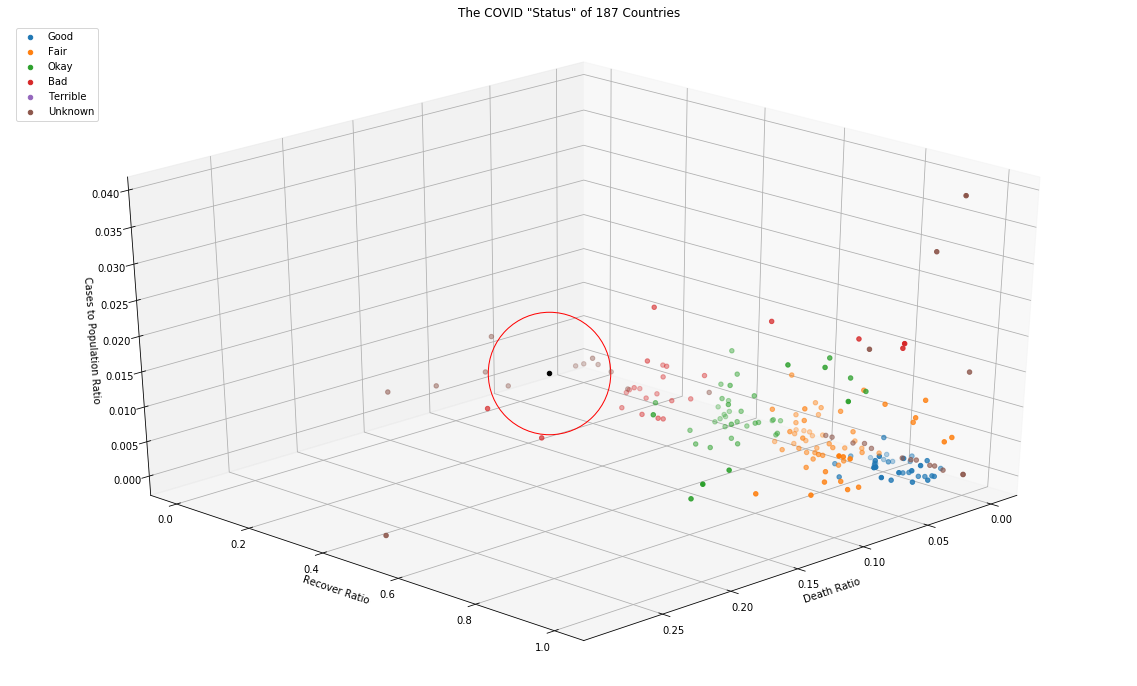

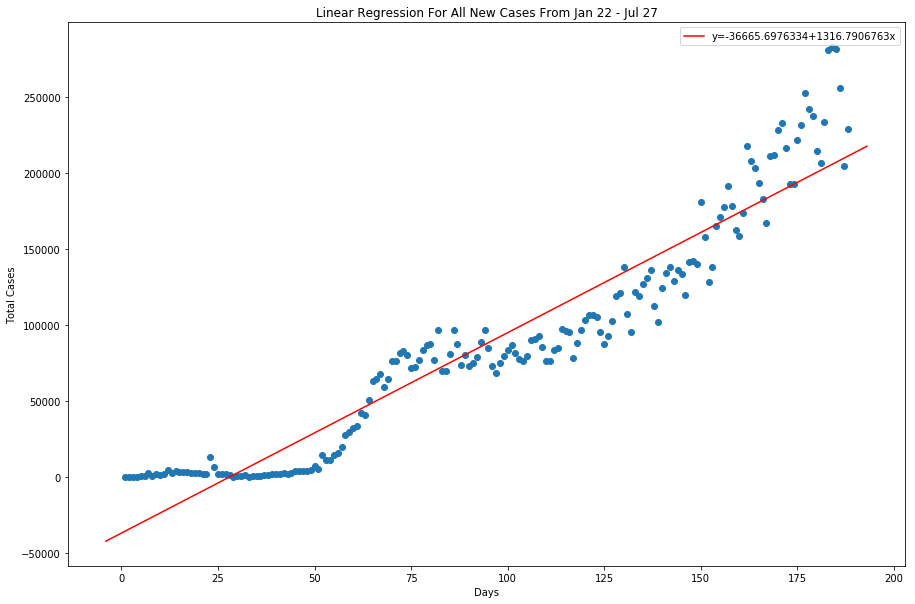

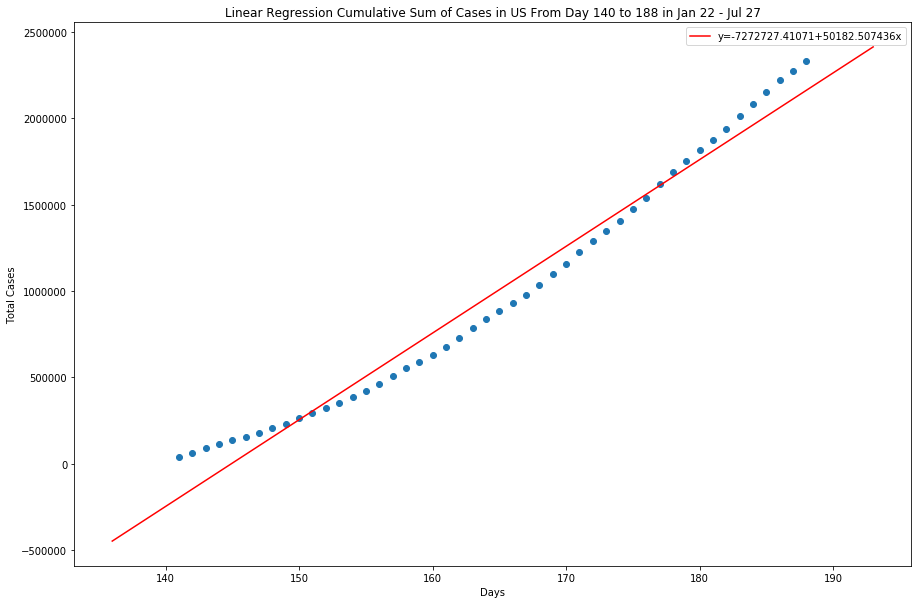

In [2]:
# Altered class from Lab 06 to calculate the k-Nearest-Neighbor.
class kNN:
    def __init__(self, train_data, full_data, labels, k):
        super().__init__()
        self.k = k
        self.labels = labels
        self.distance = None
        self.train(train_data, full_data)
        
    def train(self, train_data, full_data):
        self.full_data = full_data
        self.train_data = train_data
        self.train_size = train_data.shape[0]
        
    def distances(self, sample):
        diffMatrix = tile(sample, (self.train_size, 1)) - self.train_data
        self.distance = ((diffMatrix ** 2).sum(axis = 1) ** 0.5)

    def predict(self, sample):
        self.distances(sample)
        sortedIndices = self.distance.argsort()
        
        label_count = []
        for i in range(len(self.labels)):
            label_count.append(0)
        
        Class = ''
        for num in range(self.k):
            votedPoints = sortedIndices[num]
            for label in self.labels:
                if self.full_data[votedPoints][3] == label:
                    label_count[self.labels.index(label)] += 1
                
        values = array(label_count).argsort()
        Class = self.labels[values[len(self.labels)-1]]
        
        return Class
    
    def print_plot(self, sample):
        plots = []
        fig = plt.figure(figsize=(20, 12))
        ax = fig.add_subplot(111, projection='3d')
        
        for i in range(len(self.labels)):
            plots.append(([], [], []))
        
        for num in range(self.train_size):
            plots[self.labels.index(self.full_data[num][3])][0].append(self.train_data[num][0])
            plots[self.labels.index(self.full_data[num][3])][1].append(self.train_data[num][1])
            plots[self.labels.index(self.full_data[num][3])][2].append(self.train_data[num][2])

        ax.set_xlabel('Death Ratio')
        ax.set_ylabel('Recover Ratio')
        ax.set_zlabel('Cases to Population Ratio')
        
        for sett in plots:
            ax.scatter(sett[0], sett[1], sett[2])
        ax.legend(self.labels, loc='upper left')
        ax.title.set_text('The COVID "Status" of 187 Countries')
        ax.scatter(sample[0], sample[1], sample[2], c='#000000')
        ax.scatter(sample[0], sample[1], sample[2], s=15000, facecolor='none', edgecolors='r')
        ax.view_init(30, 45)
        
################################################################

# Calculate 'death rates' and 'recovery rates' for each country to classify them.
Recovery = COVID[['count-reg', 'case', 'death', 'recover']].groupby(['count-reg']).max().sort_values(['count-reg'], ascending=True)
Recovery['recoverratio'] = Recovery['recover'] / Recovery['case']
Recovery['deathratio'] = Recovery['death'] / Recovery['case']

Proportion = COVID2[['Population', 'Total Cases']]
Proportion['Prop'] = Proportion['Total Cases'] / Proportion['Population']

Recovery = pd.DataFrame(dict(dr=Recovery['deathratio'].values, rr=Recovery['recoverratio'].values, prop=Proportion['Prop'].values))
Recovery.reset_index(drop=True)

# Set up the data by giving them labels based on above rates.
full_data = []
train_data = []
for num in range(len(Recovery)):
    full_data.append([Recovery['dr'][num], Recovery['rr'][num], Recovery['prop'][num]])
    train_data.append([Recovery['dr'][num], Recovery['rr'][num], Recovery['prop'][num]])
    
# Assigning covid-19 status.
for point in full_data:
    if point[0] == 0.00 or point[1] == 0.00 or point[2] == 0.00:
        point.append('Unknown')
    elif point[0] <= 0.05 and point[1] >= 0.80 and point[2] <= 0.005:
        point.append('Good')
    elif point[0] <= 0.10 and point[1] >= 0.60 and point[2] <= 0.010:
        point.append('Fair')
    elif point[0] <= 0.15 and point[1] >= 0.40 and point[2] <= 0.015:
        point.append('Okay')
    elif point[0] <= 0.20 and point[1] >= 0.20 and point[2] <= 0.02:
        point.append('Bad')
    elif point[0] > 0.20 and point[1] < 0.20 and point[2] > 0.02:
        point.append('Terrible')
        
for point in full_data:
    if len(point) == 3:
        point.append('Unknown')

# Run the model and make predictions.
test_data = [[0.08, 0.72, 0.008], [0.02, 0.93, 0.0012], [0.22, 0.18, 0.05], [0.14, 0.40, 0.013]]
model = kNN(array(train_data), array(full_data), ['Good', 'Fair', 'Okay', 'Bad', 'Terrible', 'Unknown'], 11)
print('The country\'s Covid-19 status is:', model.predict(array(test_data[3])))
model.print_plot(array(test_data[3]))

####################### LINEAR REGRESSION #######################
class Linear_Regression:
    def __init__(self, x, y, xlabel, ylabel, title):
        super().__init__()
        self.n = len(x)
        self.x = x
        self.y = y
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.title = title
        self.set_values()
        self.calculate()
        self.plot_data()
        
    def set_values(self):
        self.sumx = sum(self.x)
        self.sumy = sum(self.y)
        self.sumxsq = sum(square(self.x))
        self.sumysq = sum(square(self.y))
        self.sumxy = sum(multiply(self.x, self.y))
        
    def calculate(self):
        self.a = divide(subtract(multiply(self.sumy, self.sumxsq), multiply(self.sumx, self.sumxy)), subtract(multiply(self.n, self.sumxsq), multiply(self.sumx, self.sumx)))
        self.b = divide(subtract(multiply(self.n, self.sumxy), multiply(self.sumx, self.sumy)), subtract(multiply(self.n, self.sumxsq), square(self.sumx)))
    
    def plot_data(self):
        self.plotx = linspace(min(self.x) - 5, max(self.x) + 5, 188)
        self.ploty = self.a + self.b * self.plotx
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(111)
        ax.scatter(self.x, self.y)
        ax.set_xlabel(self.xlabel)
        ax.set_ylabel(self.ylabel)
        ax.plot(self.plotx, self.ploty, '-r', label='y=' + str(self.a) + '+' + str(self.b) + 'x')
        ax.legend(loc='best')
        ax.title.set_text(self.title)
    
    
total_new_cases = COVID[['date', 'count-reg', 'ncase']].groupby(['date']).sum()

xvalues, yvalues = [], []
for num in range(len(total_new_cases.values)):
    xvalues.append(num + 1)
    yvalues.append(total_new_cases.values[num][0])
    
LR = Linear_Regression(xvalues, yvalues, 'Days', 'Total Cases', 'Linear Regression For All New Cases From Jan 22 - Jul 27')

def plot_country_LR(country, datarange):
    data = COVID['count-reg'].head(188)
    data = list(data.values)
    try:
        pos = data.index(country)
    except:
        print("Country not found.")
    
    xvalues, yvalues = [], []
    for num in range(datarange[0], datarange[1]):
        xvalues.append(num + 1)
        yvalues.append(COVID.loc[pos + (187 * num)]['ncase'])
        if num != 0:
            yvalues[len(yvalues) - 1] = yvalues[len(yvalues) - 1] + yvalues[len(yvalues) - 2]
            
    title =  'Linear Regression Cumulative Sum of Cases in ' + country +' From Day ' + str(datarange[0]) + ' to ' + str(datarange[1]) + ' in Jan 22 - Jul 27'
    LR = Linear_Regression(xvalues, yvalues, 'Days', 'Total Cases', title)

plot_country_LR('US', (140, 188))


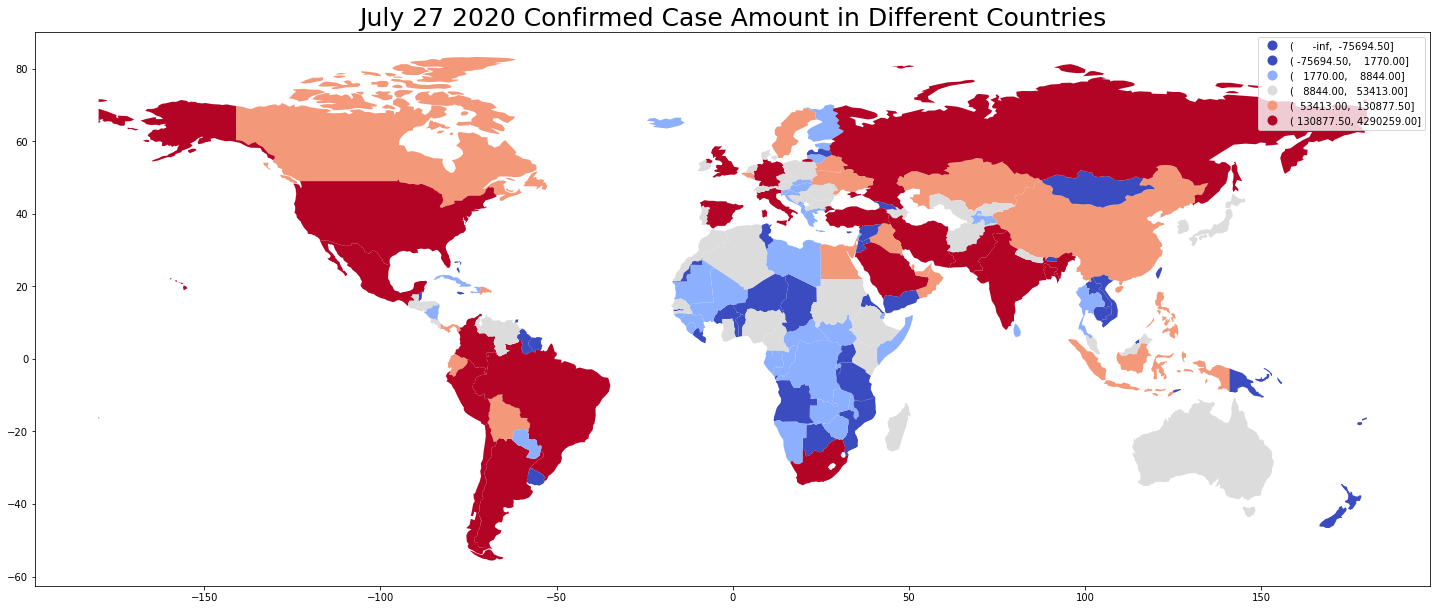

In [32]:
import geopandas 
import pycountry

# Converts country names to 3 character country codes 
def alpha3code(column):
    CODE=[]
    for country in column:
        if(pycountry.countries.get(common_name=country) is not None):
            code = pycountry.countries.get(common_name=country).alpha_3
        elif (pycountry.countries.get(name=country) is not None):
            code = pycountry.countries.get(name=country).alpha_3
        else:
            code = 'None'
        CODE.append(code)
    return CODE
# Creates a list of country codes 
COVID3['CODE']=alpha3code(COVID3.count_reg)
# of country names
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns = ['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# Merges the country names with COVID
merge = pd.merge(world,COVID3,on = 'CODE')
# Gets longitude an latitude lines
location = pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
# Merges Country location
merge = merge.merge(location,on = 'name').sort_values(by = ['date','count_reg'],ascending=True).reset_index()
# Reduces dataframe to be the most recent days only 
mrg = merge[(157*187):(157*188)]
# Makes the plot
mrg.plot(column='case', scheme="boxplot", figsize=(25, 20), legend=True,cmap='coolwarm')
plt.title('July 27 2020 Confirmed Case Amount in Different Countries', fontsize=25) 
plt.show()